In [46]:
import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f #isnull, when, count, col, substring, date_format
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.style.use('ggplot')

# starts the spark session that uses: 4 cores, sql and rdd contexts
# note: this spark session only uses the local machine
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

# a sparkcontext which makes rdds
sc = spark.sparkContext

# ====LA starts here====

In [98]:
# LA's timestamps unfortunately come in two different formats but spark can't handle it well. Pandas fortunately does and it can handle the size of this data ok so we can have them do it.

la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true')

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat|  start_lon|end_station|  end_lat|    end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00| 

In [9]:
la_sdf.describe().show()

+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|summary|             trip_id|          duration|   start_time|     end_time|    start_station|          start_lat|          start_lon|       end_station|            end_lat|            end_lon|           bike_id|     plan_duration|trip_route_category|passholder_type|
+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|  count|              812210|            812210|       812210|       812210|           812210|             761956|             761956|            812210|             787561|             787561

In [49]:
la_sdf.count()

812210

In [18]:
# dataframe loses ~69,000 rows after dropping any that have null elements

la_sdf.dropna(how='any').count()

742859

In [48]:
# modified line from stack overflow, counts the number of null values in each column

la_sdf.select([count(when(isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|      0|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



So the only null values in the LA data are latitudes and longitudes. There must be one or more stations that don't have lat/long data. Since we aren't doing any mapping data, this shouldn't matter. We couldn't realistically calculate distance with these coordinates anyways.

In [19]:
la_sdf.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station: string (nullable = true)
 |-- start_lat: string (nullable = true)
 |-- start_lon: string (nullable = true)
 |-- end_station: string (nullable = true)
 |-- end_lat: string (nullable = true)
 |-- end_lon: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- plan_duration: string (nullable = true)
 |-- trip_route_category: string (nullable = true)
 |-- passholder_type: string (nullable = true)



In [31]:
# this time with schema

la_schema = StructType([
    StructField('trip_id', IntegerType(), True), # primary key
    StructField('duration', IntegerType(), True), # duration in minutes, may want to remove trips below 5 minutes or over x hours
    StructField('start_time', StringType(), True), # ISO 8601 (local time), TimestampType drops 1/3 of the data
    StructField('end_time', StringType(), True),
    StructField('start_station', IntegerType(), True), # foreign key, station names exist online somewhere
    StructField('start_lat', FloatType(), True), # useful if looking for geographic data
    StructField('start_lon', FloatType(), True),
    StructField('end_station', IntegerType(), True),
    StructField('end_lat', FloatType(), True),
    StructField('end_lon', FloatType(), True),
    StructField('bike_id', IntegerType(), True), # foreign key
    StructField('plan_duration', IntegerType(), True), # days rider has had their pass, 0 or 1 (?) for "walk up"
    StructField('trip_route_category', StringType(), True), # "Round Trip" or "One Way"
    StructField('passholder_type', StringType(), True)
    #, StructField('bike_type', StringType(), True)
])

la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true', inferSchema=False, schema=la_schema)

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00|         4147| 3

In [32]:
# If you want to run some certain analysis, start here with picking the relevant columns

use_cols = ['duration', 'start_time', 'plan_duration']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_to_pd = la_sdf.drop(*drop_cols)

la_sdf_to_pd.show()

+--------+-------------------+-------------+
|duration|         start_time|plan_duration|
+--------+-------------------+-------------+
|       8|2018-07-01 00:04:00|           30|
|       8|2018-07-01 00:04:00|          365|
|      15|2018-07-01 00:09:00|          365|
|       7|2018-07-01 00:22:00|           30|
|      35|2018-07-01 00:23:00|            1|
|       6|2018-07-01 00:38:00|            1|
|       5|2018-07-01 00:39:00|            1|
|      33|2018-07-01 00:40:00|            1|
|       6|2018-07-01 00:44:00|           30|
|       3|2018-07-01 00:46:00|           30|
|       7|2018-07-01 00:49:00|            1|
|       7|2018-07-01 00:49:00|            1|
|      19|2018-07-01 00:51:00|            1|
|      19|2018-07-01 00:51:00|            1|
|      16|2018-07-01 01:10:00|           30|
|       2|2018-07-01 01:29:00|           30|
|      21|2018-07-01 01:32:00|            1|
|     383|2018-07-01 01:35:00|           30|
|      17|2018-07-01 01:47:00|            1|
|      17|

There are trips that are below 3 minutes (duration = 2) where the rider made it from one station to another. So although the data will include rider or machine error that inflates the number of rides, at least for LA we can't realistically pull all the short trips without throwing out real data. An argument could be made for short "round trip" rows, but it's hard to say what the limit should be (2 minutes? 5? 10?).

In [128]:
la_df = la_sdf_to_pd.toPandas()

la_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812210 entries, 0 to 812209
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   duration       812210 non-null  int32 
 1   start_time     812210 non-null  object
 2   plan_duration  812210 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 12.4+ MB


In [129]:
# make our start_time column into a datetime format, remove feb 29th from 2020

la_df['start_time'] = pd.to_datetime(la_df['start_time'], infer_datetime_format=True)

la_df = la_df[~((la_df['start_time'].dt.month == 2) & (la_df['start_time'].dt.day == 29))]

la_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811227 entries, 0 to 812209
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   duration       811227 non-null  int32         
 1   start_time     811227 non-null  datetime64[ns]
 2   plan_duration  811227 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 18.6 MB


In [38]:
la_df_2018 = la_df[la_df['start_time'].dt.year == 2018]

la_df_2018 = la_df_2018.groupby(la_df_2018['start_time'].dt.month).size()/1000

la_df_2019 = la_df[la_df['start_time'].dt.year == 2019]

la_df_2019 = la_df_2019.groupby(la_df_2019['start_time'].dt.month).size()/1000

la_df_2020 = la_df[la_df['start_time'].dt.year == 2020]

la_df_2020 = la_df_2020.groupby(la_df_2020['start_time'].dt.month).size()/1000

In [39]:
la_df_2018

start_time
1     22.221
2     19.987
3     23.179
4     24.863
5     26.115
6     26.379
7     30.350
8     33.328
9     31.605
10    28.925
11    23.953
12    20.989
dtype: float64

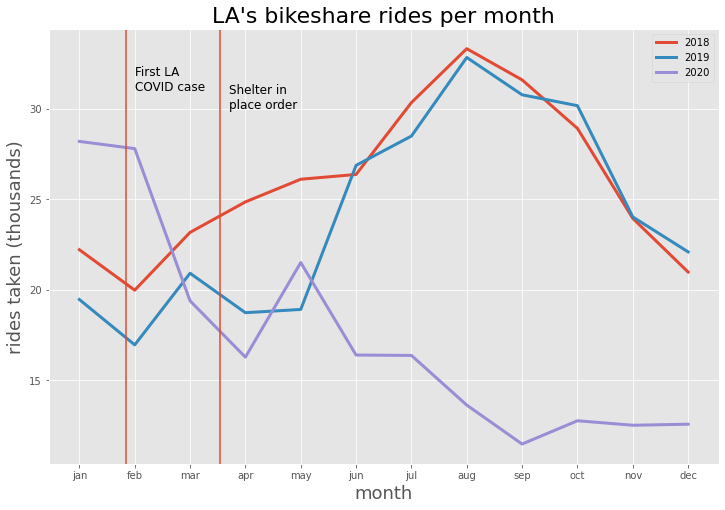

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

x = [1,2,3,4,5,6,7,8,9,10,11,12]

ax.plot(x, la_df_2018, label='2018', linewidth=3)
ax.plot(x, la_df_2019, label='2019', linewidth=3)
ax.plot(x, la_df_2020, label='2020', linewidth=3)
ax.axvline(x= 1 + 26/31)
ax.text(2, 31, 'First LA\nCOVID case', fontsize=12)
ax.axvline(x= 3 + 17/31)
ax.text(3.7, 30, 'Shelter in\nplace order', fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('rides taken (thousands)', fontsize=18)
ax.set_title("LA's bikeshare rides per month", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_volume.png');

link for desc: https://data.world/makeovermonday/2021w1

TIME PERMITTING: make a long graph of above

In [135]:
# Jan/Feb kind of reduce effect size of pandemic in 2020, but leaving '18 and '19 with two extra months inflates the difference between years
# Solution: remove from all years

la_df_2018_hr = la_df[(la_df['start_time'].dt.year == 2018)] & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2018_hr = la_df_2018_hr.groupby(la_df_2018_hr['start_time'].dt.hour).size()

la_df_2019_hr = la_df[(la_df['start_time'].dt.year == 2019) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2019_hr = la_df_2019_hr.groupby(la_df_2019_hr['start_time'].dt.hour).size()

la_df_2020_hr = la_df[(la_df['start_time'].dt.year == 2020) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2020_hr = la_df_2020_hr.groupby(la_df_2020_hr['start_time'].dt.hour).size()

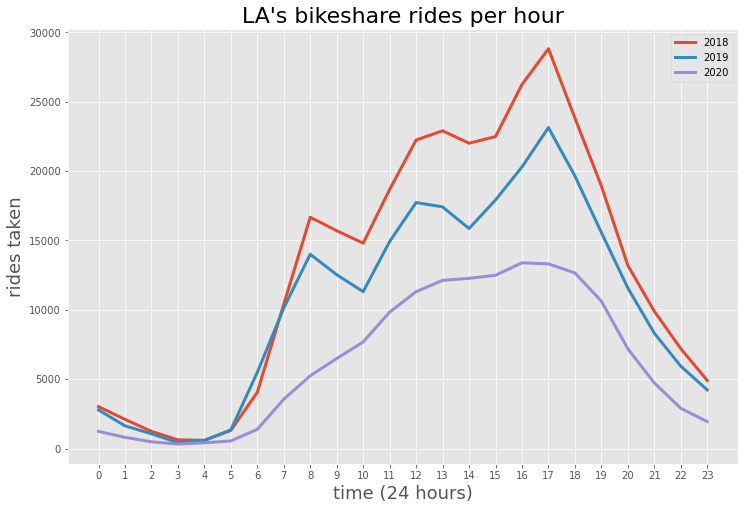

In [136]:
fig, ax = plt.subplots(figsize=(12,8))

x = [x for x in range(24)]

ax.plot(x, la_df_2018_hr, label='2018', linewidth=3)
ax.plot(x, la_df_2019_hr, label='2019', linewidth=3)
ax.plot(x, la_df_2020_hr, label='2020', linewidth=3)

ax.set_xticks(x)
#ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('time (24 hours)', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("LA's bikeshare rides per hour", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_hour.png');

Important note: in graph above Jan and Feb were excluded from all years to make a more balanced comparison

In [99]:
# New analysis: ridership over different weekdays

use_cols = ['start_time', 'plan_duration']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_wd = la_sdf.drop(*drop_cols)

#la_sdf_wd = (la_sdf_wd.withColumn('date', la_sdf_wd.start_time.cast(DateType()))
#             .withColumn('year', f.date_format('date', 'y'))
#             .withColumn('weekday', f.date_format('date', 'E'))
#             .drop('start_time')
#            .drop('date'))

la_sdf_wd.show()

+-------------------+-------------+
|         start_time|plan_duration|
+-------------------+-------------+
|2018-07-01 00:04:00|           30|
|2018-07-01 00:04:00|          365|
|2018-07-01 00:09:00|          365|
|2018-07-01 00:22:00|           30|
|2018-07-01 00:23:00|            1|
|2018-07-01 00:38:00|            1|
|2018-07-01 00:39:00|            1|
|2018-07-01 00:40:00|            1|
|2018-07-01 00:44:00|           30|
|2018-07-01 00:46:00|           30|
|2018-07-01 00:49:00|            1|
|2018-07-01 00:49:00|            1|
|2018-07-01 00:51:00|            1|
|2018-07-01 00:51:00|            1|
|2018-07-01 01:10:00|           30|
|2018-07-01 01:29:00|           30|
|2018-07-01 01:32:00|            1|
|2018-07-01 01:35:00|           30|
|2018-07-01 01:47:00|            1|
|2018-07-01 01:47:00|            1|
+-------------------+-------------+
only showing top 20 rows



In [100]:
# Fix up one column to tell us about membership

def dummy_code_users_la(col):
    # The plan_duration column tells how many days a bike pass lasts. If it's 1 day, it's just a walkup, not a member.
    # We're returning "is this row a member? 1: yes, 0: no."
    if col == '1':
        return 0
    else:
        return 1

udf = f.UserDefinedFunction(dummy_code_users_la, IntegerType())

la_sdf_wd = la_sdf_wd.withColumn('usertype', udf('plan_duration')).drop('plan_duration')

la_sdf_wd.show()

+-------------------+--------+
|         start_time|usertype|
+-------------------+--------+
|2018-07-01 00:04:00|       1|
|2018-07-01 00:04:00|       1|
|2018-07-01 00:09:00|       1|
|2018-07-01 00:22:00|       1|
|2018-07-01 00:23:00|       0|
|2018-07-01 00:38:00|       0|
|2018-07-01 00:39:00|       0|
|2018-07-01 00:40:00|       0|
|2018-07-01 00:44:00|       1|
|2018-07-01 00:46:00|       1|
|2018-07-01 00:49:00|       0|
|2018-07-01 00:49:00|       0|
|2018-07-01 00:51:00|       0|
|2018-07-01 00:51:00|       0|
|2018-07-01 01:10:00|       1|
|2018-07-01 01:29:00|       1|
|2018-07-01 01:32:00|       0|
|2018-07-01 01:35:00|       1|
|2018-07-01 01:47:00|       0|
|2018-07-01 01:47:00|       0|
+-------------------+--------+
only showing top 20 rows



In [101]:
la_df_wd = la_sdf_wd.toPandas()

la_df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812210 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   start_time  812210 non-null  object
 1   usertype    812210 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 9.3+ MB


In [102]:
# cast start_time to datetime type

la_df_wd['start_time'] = pd.to_datetime(la_df_wd['start_time'], infer_datetime_format=True)

la_df_wd.head()

,start_time,usertype
0,2018-07-01 00:04:00,1
1,2018-07-01 00:04:00,1
2,2018-07-01 00:09:00,1
3,2018-07-01 00:22:00,1
4,2018-07-01 00:23:00,0


In [117]:
la_df_wd18 = la_df_wd.copy()
la_df_wd19 = la_df_wd.copy()
la_df_wd20 = la_df_wd.copy()

la_df_wd18['usertype2'] = la_df_wd18['usertype']
la_df_wd19['usertype2'] = la_df_wd19['usertype']
la_df_wd20['usertype2'] = la_df_wd20['usertype']

In [118]:
# make a dataframe of relevant data for each year
# modifies dataframes directly, run cell above to reset

la_df_wd18 = (la_df_wd18[la_df_wd18['start_time'].dt.year == 2018]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd19 = (la_df_wd19[la_df_wd19['start_time'].dt.year == 2019]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd20 = (la_df_wd20[la_df_wd20['start_time'].dt.year == 2020]
              .groupby(la_df_wd['start_time'].dt.date)
              .agg({'usertype':'count', 'usertype2':'sum'})
              .reset_index()
              .rename(columns={'usertype':'ride_count', 'usertype2':'member_count', 'start_time':'date'}))

la_df_wd20

,date,ride_count,member_count
0,2020-01-01,572,357
1,2020-01-02,901,651
2,2020-01-03,972,748
3,2020-01-04,685,473
4,2020-01-05,632,484
...,...,...,...
361,2020-12-27,476,262
362,2020-12-28,103,90
363,2020-12-29,433,267
364,2020-12-30,407,206


In [137]:
# from here you'd make a graph (see Chicago for template)

In [47]:
# Getting ride counts per day for hypothesis testing

# Pyspark can't handle multiple date formats so we first get a pandas df and do ride count there (only works with smaller datasets like LA)

use_cols = ['start_time']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_dy = la_sdf.drop(*drop_cols)

la_df_dy = la_sdf_dy.toPandas()

la_df_dy['start_time'] = pd.to_datetime(la_df_dy['start_time'], infer_datetime_format=True)

la_df_dy

#la_df_dy = la_df_dy.groupby(la_df_dy['start_time'].dt.date).count()

,start_time
0,2018-07-01 00:04:00
1,2018-07-01 00:04:00
2,2018-07-01 00:09:00
3,2018-07-01 00:22:00
4,2018-07-01 00:23:00
...,...
812205,2020-12-31 23:00:00
812206,2020-12-31 23:06:00
812207,2020-12-31 23:42:00
812208,2020-12-31 23:42:00


In [48]:
la_df_dy = (la_df_dy.groupby(la_df_dy['start_time'].dt.date).count()
                .rename(columns={'start_time':'ride_ct'})
                .reset_index()
                .rename(columns={'start_time':'date'}))

# Then throw this with the respective chicago one for hypothesis testing
la_df_dy

,date,ride_ct
0,2018-01-01,781
1,2018-01-02,765
2,2018-01-03,717
3,2018-01-04,736
4,2018-01-05,742
...,...,...
1091,2020-12-27,476
1092,2020-12-28,103
1093,2020-12-29,433
1094,2020-12-30,407


In [49]:
# This doesn't stick for whatever reason above so do it again
la_df_dy['date'] = pd.to_datetime(la_df_dy['date'], infer_datetime_format=True)

# ====Chicago starts here====

In [3]:
# Two zip files also came out without the .csv in their file name, needed to be manually added

# Data comes in three distinct layouts: 2018 Q1 and 2019 Q2 look like other pre 2020 layouts w/ longer column names
# From 2020 on data includes bike type but drops gender and ride duration

# Make the first of three dataframes to be put together later
ch_sdf_set1 = spark.read.csv(['data/CH/Divvy_Trips_2018_Q1.csv', 'data/CH/Divvy_Trips_2019_Q2.csv'], header='true')

# Pick which columns we want (if you want more you have to do this for all three sets)
# For .py may want to leave all columns you can so you can def return a "complete" df for analysis
use_cols = ['01 - Rental Details Local End Time', '01 - Rental Details Local Start Time', 'User Type']
drop_cols = ch_sdf_set1.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop columns we don't want and rename what we're keeping
ch_sdf_set1 = (ch_sdf_set1.drop(*drop_cols)
               .withColumnRenamed('01 - Rental Details Local Start Time', 'start_time')
               .withColumnRenamed('01 - Rental Details Local End Time', 'end_time')
               .withColumnRenamed('user type', 'usertype'))

def dummy_code_users_ch(col):
    if col == 'Subscriber' or col == 'member':
        return 1
    else:
        return 0

udf = f.UserDefinedFunction(dummy_code_users_ch, IntegerType())

ch_sdf_set1 = ch_sdf_set1.withColumn('usertype', udf('usertype'))

ch_sdf_set1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [4]:
# Now for the rest of the pre-2020 data

# Gather all files
filelist = []
for quarter in [2,3,4]:
    filelist.append('data/CH/Divvy_Trips_2018_Q{}.csv'.format(quarter))
for quarter in [1,3,4]:
    filelist.append('data/CH/Divvy_Trips_2019_Q{}.csv'.format(quarter))

# Make the dataframe
ch_sdf_set2 = spark.read.csv(filelist, header='true')

# Pick which columns we want
use_cols = ['start_time', 'end_time', 'usertype']
drop_cols = ch_sdf_set2.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop the columns we don't want (no need to rename here)
ch_sdf_set2 = ch_sdf_set2.drop(*drop_cols)

# Using user defined function we made above
ch_sdf_set2 = ch_sdf_set2.withColumn('usertype', udf('usertype'))

ch_sdf_set2.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [5]:
# And finally the post-2020 data

# Gather all the files
filelist = ['data/CH/Divvy_Trips_2020_Q1.csv']
for month in range(4,13):
    filelist.append('data/CH/2020{0:0=2d}-divvy-tripdata.csv'.format(month))

# Make the dataframe
ch_sdf_set3 = spark.read.csv(filelist, header='true')

# Pick which columns we want
use_cols = ['started_at', 'ended_at', 'member_casual']
drop_cols = ch_sdf_set3.columns
for col in use_cols:
    drop_cols.remove(col)

# Drop the columns we don't want and rename what we're keeping
ch_sdf_set3 = (ch_sdf_set3.drop(*drop_cols)
               .withColumnRenamed('started_at', 'start_time')
               .withColumnRenamed('ended_at', 'end_time')
               .withColumnRenamed('member_casual', 'usertype'))

ch_sdf_set3 = ch_sdf_set3.withColumn('usertype', udf('usertype'))

ch_sdf_set3.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- usertype: integer (nullable = true)



In [6]:
# Complete chicago DF ends up here before being sliced for whatever analysis

ch_sdf = ch_sdf_set1.union(ch_sdf_set2).union(ch_sdf_set3)

ch_sdf.show()

+-------------------+-------------------+--------+
|         start_time|           end_time|usertype|
+-------------------+-------------------+--------+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|
|2019-04-01 00:03:02|2019-04-01 00:20:30|       1|
|2019-04-01 00:11:07|2019-04-01 00:15:19|       1|
|2019-04-01 00:13:01|2019-04-01 00:18:58|       1|
|2019-04-01 00:19:26|2019-04-01 00:36:13|       1|
|2019-04-01 00:19:39|2019-04-01 00:23:56|       1|
|2019-04-01 00:26:33|2019-04-01 00:35:41|       1|
|2019-04-01 00:29:48|2019-04-01 00:36:11|       1|
|2019-04-01 00:32:07|2019-04-01 01:07:44|       0|
|2019-04-01 00:32:19|2019-04-01 01:07:39|       0|
|2019-04-01 00:36:20|2019-04-01 00:41:17|       1|
|2019-04-01 00:58:38|2019-04-01 01:04:43|       1|
|2019-04-01 01:09:41|2019-04-01 01:12:26|       1|
|2019-04-01 01:13:15|2019-04-01 01:20:38|       1|
|2019-04-01 01:18:09|2019-04-01 01:23:02|       1|
|2019-04-01 01:28:21|2019-04-01 01:31:45|       1|
|2019-04-01 01:31:35|2019-04-01

In [8]:
# Data too big to throw into pandas, and datetime types weren't doing us any favors
# so we'll grab necessary info through spark.

ch_sdf_months = (ch_sdf.withColumn('date', ch_sdf.start_time.cast(DateType()))
          .withColumn('year', f.date_format('date', 'y'))
          .withColumn('month', f.date_format('date', 'M')))

ch_sdf_months.show()

+-------------------+-------------------+--------+----------+----+-----+
|         start_time|           end_time|usertype|      date|year|month|
+-------------------+-------------------+--------+----------+----+-----+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|2019-04-01|2019|    4|
|2019-04-01 00:03:02|2019-04-01 00:20:30|       1|2019-04-01|2019|    4|
|2019-04-01 00:11:07|2019-04-01 00:15:19|       1|2019-04-01|2019|    4|
|2019-04-01 00:13:01|2019-04-01 00:18:58|       1|2019-04-01|2019|    4|
|2019-04-01 00:19:26|2019-04-01 00:36:13|       1|2019-04-01|2019|    4|
|2019-04-01 00:19:39|2019-04-01 00:23:56|       1|2019-04-01|2019|    4|
|2019-04-01 00:26:33|2019-04-01 00:35:41|       1|2019-04-01|2019|    4|
|2019-04-01 00:29:48|2019-04-01 00:36:11|       1|2019-04-01|2019|    4|
|2019-04-01 00:32:07|2019-04-01 01:07:44|       0|2019-04-01|2019|    4|
|2019-04-01 00:32:19|2019-04-01 01:07:39|       0|2019-04-01|2019|    4|
|2019-04-01 00:36:20|2019-04-01 00:41:17|       1|2

In [11]:
# get trip counts per month per year

ch_sdf_months18 = ch_sdf_months.filter(ch_sdf_months.year == 2018).groupBy('month').count().withColumnRenamed('count', '2018_ct')

ch_sdf_months19 = ch_sdf_months.filter(ch_sdf_months.year == 2019).groupBy('month').count().withColumnRenamed('count', '2019_ct')

ch_sdf_months20 = ch_sdf_months.filter(ch_sdf_months.year == 2020).groupBy('month').count().withColumnRenamed('count', '2020_ct')

In [12]:
# Takes a minute to run this cell, puts it all together. DAG in cell above

ch_sdf_months = ch_sdf_months18.join(ch_sdf_months19, ['month'])
ch_sdf_months = ch_sdf_months.join(ch_sdf_months20, ['month'])

ch_sdf_months.show()

+-----+-------+-------+-------+
|month|2018_ct|2019_ct|2020_ct|
+-----+-------+-------+-------+
|    7| 544703| 557315| 551480|
|   11| 168774| 177176| 259716|
|    3| 174489| 165611| 143418|
|    8| 530755| 590184| 622361|
|    5| 401150| 367458| 200274|
|    6| 458419| 475395| 343005|
|    9| 438112| 493219| 532958|
|    1| 109706| 103272| 143884|
|   10| 344940| 371786| 388653|
|    4| 200112| 265310|  84776|
|   12| 128972| 155092| 131573|
|    2| 102950|  96186| 139585|
+-----+-------+-------+-------+



In [22]:
# Moving to pandas for visualization. This dataframe is only counts, not the whole data, so it's not too big

ch_df_months = ch_sdf_months.toPandas()

ch_df_months

,month,2018_ct,2019_ct,2020_ct
0,7,544703,557315,551480
1,11,168774,177176,259716
2,3,174489,165611,143418
3,8,530755,590184,622361
4,5,401150,367458,200274
5,6,458419,475395,343005
6,9,438112,493219,532958
7,1,109706,103272,143884
8,10,344940,371786,388653
9,4,200112,265310,84776


In [23]:
# don't run repeatedly, or values will shrink

ch_df_months = ch_df_months.astype('int32').sort_values(by=['month'])

ch_df_months['2018_ct'] = ch_df_months['2018_ct']/1000
ch_df_months['2019_ct'] = ch_df_months['2019_ct']/1000
ch_df_months['2020_ct'] = ch_df_months['2020_ct']/1000

ch_df_months

,month,2018_ct,2019_ct,2020_ct
7,1,109.706,103.272,143.884
11,2,102.950,96.186,139.585
2,3,174.489,165.611,143.418
9,4,200.112,265.310,84.776
4,5,401.150,367.458,200.274
5,6,458.419,475.395,343.005
0,7,544.703,557.315,551.480
3,8,530.755,590.184,622.361
6,9,438.112,493.219,532.958
8,10,344.940,371.786,388.653


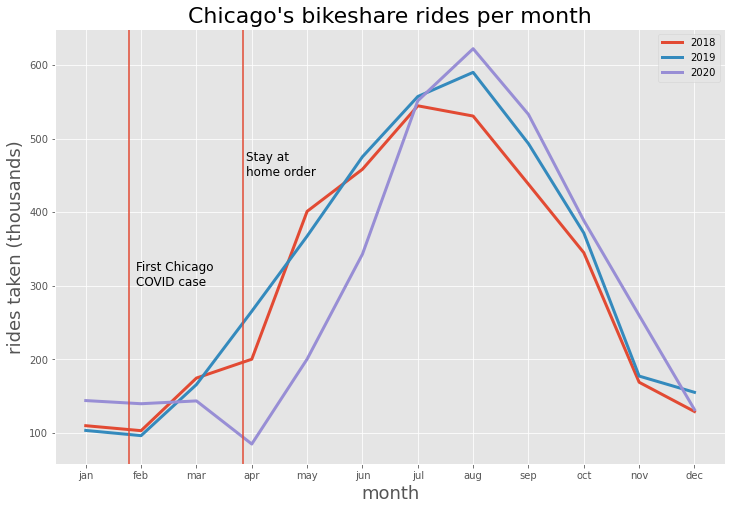

In [45]:
# plot

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(ch_df_months['month'], ch_df_months['2018_ct'], label='2018', linewidth=3)
ax.plot(ch_df_months['month'], ch_df_months['2019_ct'], label='2019', linewidth=3)
ax.plot(ch_df_months['month'], ch_df_months['2020_ct'], label='2020', linewidth=3)

ax.axvline(x= 1 + 24/31)
ax.text(1.9, 300, 'First Chicago\nCOVID case', fontsize=12)
ax.axvline(x= 3 + 26/31)
ax.text(3.9, 450, 'Stay at\nhome order', fontsize=12)
# Vertical line in July correlated w/ volume bouncing back. May not actually explain trend
#ax.axvline(x= 7 + 24/31)
#ax.text(8, 300000, 'Phase IV\nbusinesses reopen', fontsize=12)

ax.set_xticks(ch_df_months['month'])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('rides taken (thousands)', fontsize=18)
ax.set_title("Chicago's bikeshare rides per month", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

So chicago did not see the same kind of hit as LA did (proportionally). By fall the program even continued its trend of growing each year. There are lots of potential explanations which could be investigated: Are Chicago's bike users are more established? Does LA has better established alternative forms of transportation? Did Chicago not enforce social distancing? Unfortunately these are beyond the scope of this analysis.

Potential hypothesis questions: Is the 2020 bikeshare volume drop different between LA and Chicago?

may want to graph total rides vs day of week but as a bar graph - subscribers or walk up; potential ideas: https://ashkansaboori.github.io/Files/2017-03-19-Insight%20into%20bike%20sharing%20in%20Bay%20Area.html

In [137]:
# New analysis: ridership over different weekdays

ch_sdf_wd = (ch_sdf.withColumn('date', ch_sdf.start_time.cast(DateType()))
             .withColumn('year', f.date_format('date', 'y'))
             .withColumn('weekday', f.date_format('date', 'E')))

ch_sdf_wd.show()

+-------------------+-------------------+--------+----------+----+-------+
|         start_time|           end_time|usertype|      date|year|weekday|
+-------------------+-------------------+--------+----------+----+-------+
|2019-04-01 00:02:22|2019-04-01 00:09:48|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:03:02|2019-04-01 00:20:30|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:11:07|2019-04-01 00:15:19|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:13:01|2019-04-01 00:18:58|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:19:26|2019-04-01 00:36:13|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:19:39|2019-04-01 00:23:56|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:26:33|2019-04-01 00:35:41|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:29:48|2019-04-01 00:36:11|       1|2019-04-01|2019|    Mon|
|2019-04-01 00:32:07|2019-04-01 01:07:44|       0|2019-04-01|2019|    Mon|
|2019-04-01 00:32:19|2019-04-01 01:07:39|       0|2019-04-01|2019|    Mon|
|2019-04-01 00:36:20|2019

In [138]:
# get trip counts per weeday per year

ch_sdf_wd18 = ch_sdf_wd.filter(ch_sdf_wd.year == 2018).groupBy('weekday').count().withColumnRenamed('count', '2018_ct')
ch_sdf_wd18_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2018).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2018_member_ct')

ch_sdf_wd19 = ch_sdf_wd.filter(ch_sdf_wd.year == 2019).groupBy('weekday').count().withColumnRenamed('count', '2019_ct')
ch_sdf_wd19_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2019).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2019_member_ct')

ch_sdf_wd20 = ch_sdf_wd.filter(ch_sdf_wd.year == 2020).groupBy('weekday').count().withColumnRenamed('count', '2020_ct')
ch_sdf_wd20_m = ch_sdf_wd.filter(ch_sdf_wd.year == 2020).filter(ch_sdf_wd.usertype == 1).groupBy('weekday').count().withColumnRenamed('count', '2020_member_ct')

In [139]:
# Takes a minute to run this cell, puts it all together. DAG in cell above

ch_sdf_wd = (ch_sdf_wd18.join(ch_sdf_wd18_m, ['weekday'])
             .join(ch_sdf_wd19, ['weekday'])
             .join(ch_sdf_wd19_m, ['weekday'])
             .join(ch_sdf_wd20, ['weekday'])
             .join(ch_sdf_wd20_m, ['weekday']))

ch_sdf_wd.show()

+-------+-------+--------------+-------+--------------+-------+--------------+
|weekday|2018_ct|2018_member_ct|2019_ct|2019_member_ct|2020_ct|2020_member_ct|
+-------+-------+--------------+-------+--------------+-------+--------------+
|    Sun| 405892|        260581| 426420|        256241| 527220|        271072|
|    Mon| 528569|        448097| 560269|        458780| 433696|        292044|
|    Thu| 562646|        491387| 588287|        486915| 491278|        328589|
|    Sat| 445385|        283964| 495219|        287163| 626179|        312376|
|    Wed| 576325|        504836| 584022|        494277| 482008|        329484|
|    Fri| 525681|        442978| 578107|        456966| 528235|        326048|
|    Tue| 558584|        494083| 585680|        497025| 453067|        315495|
+-------+-------+--------------+-------+--------------+-------+--------------+



In [140]:
# Moving to pandas for visualization. This dataframe is only counts, not the whole data, so it's not too big

ch_df_wd = ch_sdf_wd.toPandas()

ch_df_wd

,weekday,2018_ct,2018_member_ct,2019_ct,2019_member_ct,2020_ct,2020_member_ct
0,Sun,405892,260581,426420,256241,527220,271072
1,Mon,528569,448097,560269,458780,433696,292044
2,Thu,562646,491387,588287,486915,491278,328589
3,Sat,445385,283964,495219,287163,626179,312376
4,Wed,576325,504836,584022,494277,482008,329484
5,Fri,525681,442978,578107,456966,528235,326048
6,Tue,558584,494083,585680,497025,453067,315495


In [10]:
# Unfortunately need to sort by weekday
# Don't run this cell multiple times, 'weekday' will all become NaN

wd_sort = dict(zip(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], range(7)))

ch_df_wd['weekday'] = ch_df_wd['weekday'].map(wd_sort)

ch_df_wd.sort_values(by=['weekday'], inplace=True)

ch_df_wd

,weekday,2018_ct,2018_member_ct,2019_ct,2019_member_ct,2020_ct,2020_member_ct
1,0,528569,448097,560269,458780,433696,292044
6,1,558584,494083,585680,497025,453067,315495
4,2,576325,504836,584022,494277,482008,329484
2,3,562646,491387,588287,486915,491278,328589
5,4,525681,442978,578107,456966,528235,326048
3,5,445385,283964,495219,287163,626179,312376
0,6,405892,260581,426420,256241,527220,271072


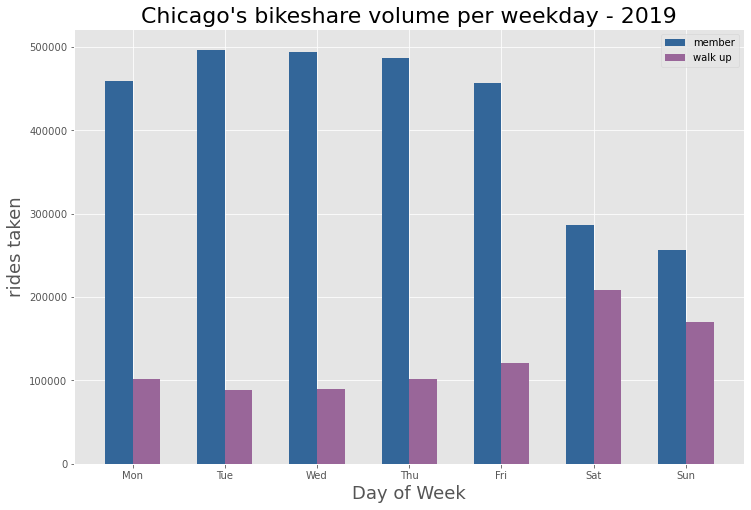

In [11]:
# visualization of rides across weekdays for members and non-members

fig, ax = plt.subplots(figsize=(12,8))

width = 0.3
ax.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2019_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2019_ct']-ch_df_wd['2019_member_ct'], width=width, align='center', label='walk up', color=(0.6, 0.4, 0.6, 1))

ax.set_xticks(ch_df_wd['weekday'])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax.set_xlabel('Day of Week', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("Chicago's bikeshare volume per weekday - 2019", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

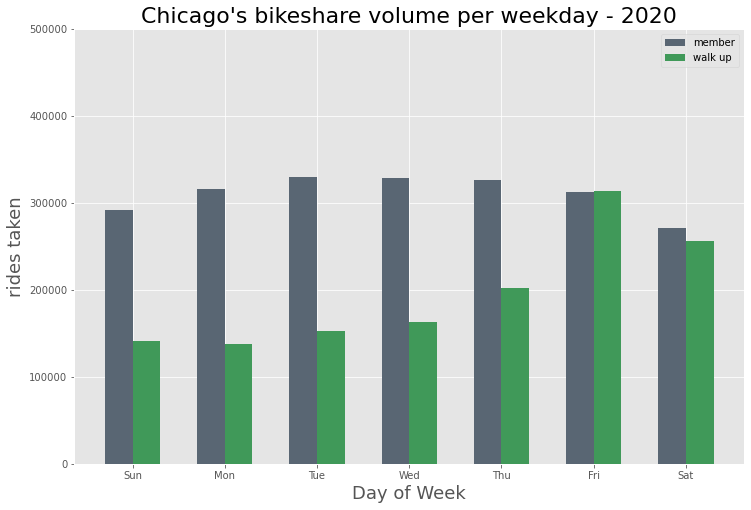

In [12]:
# comparison to 2020

fig, ax = plt.subplots(figsize=(12,8))

width = 0.3
ax.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2020_member_ct'], width=width, align='center', label='member', color=(0.35, 0.4, 0.45, 1))
ax.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2020_ct']-ch_df_wd['2020_member_ct'], width=width, align='center', label='walk up', color=(0.25, 0.6, 0.35, 1))
ax.set_ylim(0, 500000)

ax.set_xticks(ch_df_wd['weekday'])
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax.set_xlabel('Day of Week', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("Chicago's bikeshare volume per weekday - 2020", fontsize=22)

ax.legend();

#plt.savefig('graphs/chicago_volume.png');

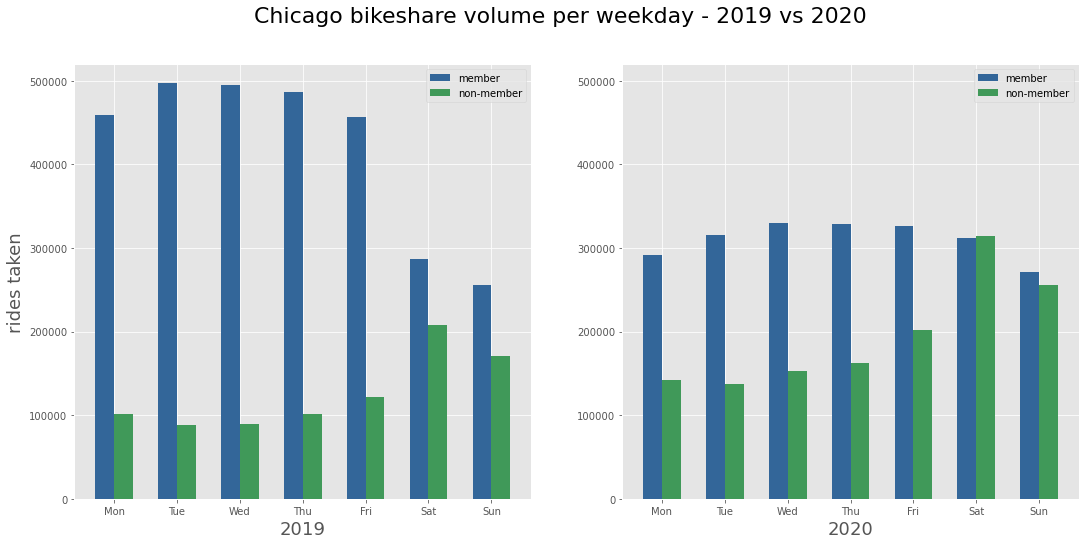

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))

width = 0.3
ax1.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2019_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax1.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2019_ct']-ch_df_wd['2019_member_ct'], width=width, align='center', label='non-member', color=(0.25, 0.6, 0.35, 1))
ax1.set_ylim(0, 520000)

ax1.set_xticks(ch_df_wd['weekday'])
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax1.set_xlabel('2019', fontsize=18)
ax1.set_ylabel('rides taken', fontsize=18)

ax1.legend()

ax2.bar(ch_df_wd['weekday']-width/2, ch_df_wd['2020_member_ct'], width=width, align='center', label='member', color=(0.2, 0.4, 0.6, 1))
ax2.bar(ch_df_wd['weekday']+width/2, ch_df_wd['2020_ct']-ch_df_wd['2020_member_ct'], width=width, align='center', label='non-member', color=(0.25, 0.6, 0.35, 1))
ax2.set_ylim(0, 520000)

ax2.set_xticks(ch_df_wd['weekday'])
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax2.set_xlabel('2020', fontsize=18)

ax2.legend()

fig.suptitle('Chicago bikeshare volume per weekday - 2019 vs 2020', fontsize=22);

#plt.savefig('graphs/chicago_weekday.png');

People are working from home yeah, but now they're saving a chunk of time not having to commute. Also after work they probably wanna get out

In [50]:
# getting a pandas df of chicago daily ride counts

ch_sdf_dy = (ch_sdf.withColumn('date', ch_sdf.start_time.cast(DateType()))
             #.withColumn('year', f.date_format('date', 'y'))
             .drop(*['start_time', 'end_time', 'usertype'])
             .groupBy('date').count()
             .withColumnRenamed('count', 'ride_ct'))

ch_sdf_dy.show()

+----------+-------+
|      date|ride_ct|
+----------+-------+
|2019-05-08|  10803|
|2019-06-04|  15878|
|2018-05-28|  17309|
|2018-08-10|  19250|
|2020-08-24|  16372|
|2018-03-17|   3937|
|2018-06-06|  17181|
|2019-11-01|   7312|
|2019-11-18|   7795|
|2019-09-22|   6901|
|2020-08-05|  17856|
|2020-07-24|  20673|
|2020-01-21|   5187|
|2020-11-29|   5453|
|2018-08-08|  19929|
|2018-08-11|  20204|
|2019-11-21|   6717|
|2018-10-05|   9710|
|2018-11-02|  10174|
|2018-09-01|   8649|
+----------+-------+
only showing top 20 rows



In [51]:
ch_df_dy = ch_sdf_dy.toPandas()

ch_df_dy['date'] = pd.to_datetime(ch_df_dy['date'], infer_datetime_format=True)

ch_df_dy.sort_values(by='date', ignore_index=True, inplace=True)

ch_df_dy

,date,ride_ct
0,2018-01-01,376
1,2018-01-02,1637
2,2018-01-03,2493
3,2018-01-04,2416
4,2018-01-05,2228
...,...,...
1089,2020-12-27,3498
1090,2020-12-28,3657
1091,2020-12-29,2655
1092,2020-12-30,1850


# ==== Hypothesis testing starts here ====

Find the difference between 18-19, the first difference score, and compare it to the difference between 19-20, the second difference score. Are these differences statistically different?

Difference in what? Total rides over the year (single number)? Average rides per day (365, mean + standev)? Week (n ~ 52)? Daily is probably the way to go.

Could compare differences in quarters instead of annual means instead (especially chicago), but quarters go up and down significantly whereas the year as a whole evens out.

In [52]:
# ch_df_dy and la_df_dy from above contain daily ride counts with all three years

ch_df = ch_df_dy.copy()
la_df = la_df_dy.copy()

la_df

,date,ride_ct
0,2018-01-01,781
1,2018-01-02,765
2,2018-01-03,717
3,2018-01-04,736
4,2018-01-05,742
...,...,...
1091,2020-12-27,476
1092,2020-12-28,103
1093,2020-12-29,433
1094,2020-12-30,407


In [53]:
# minor adjustment: remove leap day from 2020 for both cities
ch_df = ch_df[~((ch_df['date'].dt.month == 2) & (ch_df['date'].dt.day == 29))]
la_df = la_df[~((la_df['date'].dt.month == 2) & (la_df['date'].dt.day == 29))]

So now what we wanna do is take the difference in ridership from '19 to '20 on an elementwise basis, that is 365 values. Using the difference score rules out the winter/summer fluctuation (theoretically) since the difference score shouldn't change drastically weather we're comparing jan 12th or aug 12th.

Then we run two sample t-tests between quarters. Quarters will have 90, 91, and 92 days respectively. Just knock of a couple days so they're all 90 days long. We'll have six "samples": LA Q1, Q2, and Q3 next to Chicago Q1, Q2, and Q3. Are the difference scores from Q1 and Q2 different (assuming the pandemic roughly hit in the middle of those two). Are Q2 and Q3 different (long term effects)? If we ask these two questions for two cities, that makes four hypothesis tests. (adjust alpha accordingly)

H1: LA ride count difference scores (from '19-'20) are statistically significantly different between Q1 and Q2 (initial pandemic impact).

H2: LA ride count difference scores (from '19-'20) are statistically significantly different between Q2 and Q3 (long term impact).

H3: Chicago ride count difference scores (from '19-'20) are statistically significantly different between Q1 and Q2 (initial pandemic impact).

H4: Chicago ride count difference scores (from '19-'20) are statistically significantly different between Q2 and Q3 (long term impact).

In [127]:
ch_19 = ch_df[ch_df['date'].dt.year == 2019].reset_index()['ride_ct']
ch_20 = ch_df[ch_df['date'].dt.year == 2020].reset_index()['ride_ct']

stats.ttest_ind(ch_19, ch_20)

Ttest_indResult(statistic=1.4546787349905537, pvalue=0.14619042287718237)

In [78]:
# The difference score for the entire year. When this score is positive, it means 2020 had an increase for that day. The mean is how much the daily ride count average has changed from '19 to '20.

la_1920_diff = la_df[la_df['date'].dt.year == 2020].reset_index()['ride_ct'] - la_df[la_df['date'].dt.year == 2019].reset_index()['ride_ct']

la_1819_diff = la_df[la_df['date'].dt.year == 2019].reset_index()['ride_ct'] - la_df[la_df['date'].dt.year == 2018].reset_index()['ride_ct']

la_1819_diff.mean()

-59.04657534246575

In [66]:
# Same thing for Chicago

ch_1920_diff = ch_df[ch_df['date'].dt.year == 2020].reset_index()['ride_ct'] - ch_df[ch_df['date'].dt.year == 2019].reset_index()['ride_ct']

ch_1920_diff.mean()

-756.0909090909091

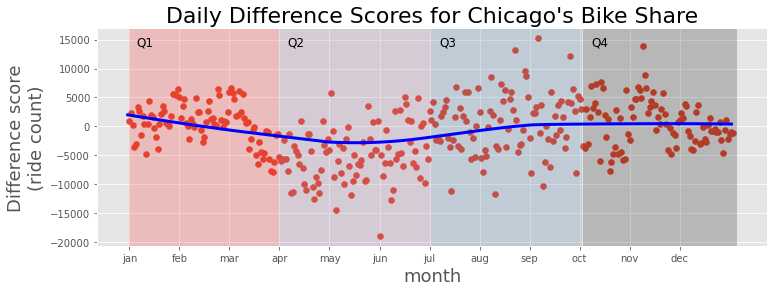

In [105]:
# May not include this graph, but it does give a nice visualization of the metric I'm using.

x = [x for x in range(1, 366)]
low20 = lowess(ch_1920_diff, x)[:,1]

fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(x, ch_1920_diff)
ax.plot(low20, linewidth=3, color='b')

# Denote quarters
ax.axvspan(1, 90, color=(1,0.1,0.1,0.2))
ax.axvspan(91, 181, color=(0.6, 0.4, 0.6, 0.2))
ax.axvspan(182, 272, color=(0.2, 0.4, 0.6, 0.2))
ax.axvspan(273, 365, color=(0,0,0,0.2))

ax.text(5, 14000, 'Q1', fontsize=12)
ax.text(96, 14000, 'Q2', fontsize=12)
ax.text(187, 14000, 'Q3', fontsize=12)
ax.text(278, 14000, 'Q4', fontsize=12)

ax.set_xticks([m for m in range(1,360,30)])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('Difference score\n(ride count)', fontsize=18)
ax.set_title("Daily Difference Scores for Chicago's Bike Share", fontsize=22);

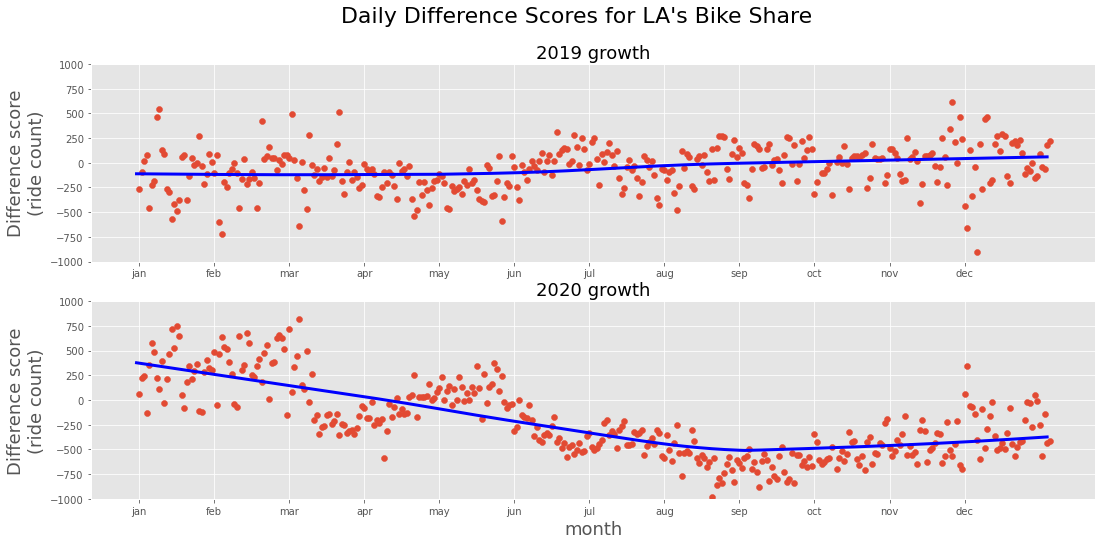

In [82]:
# May not include this graph, but it does give a nice visualization of the metric I'm using.

x = [x for x in range(1, 366)]
low19 = lowess(la_1819_diff, x)[:,1]
low20 = lowess(la_1920_diff, x)[:,1]

fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))

# '18 '19 plot
ax1.scatter(x, la_1819_diff)
ax1.plot(low19, linewidth=3, color='b')

ax1.set_xticks([m for m in range(1,360,30)])
ax1.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
ax1.set_ylim(-1000, 1000)

#ax1.set_xlabel('month', fontsize=18)
ax1.set_ylabel('Difference score\n(ride count)', fontsize=18)
ax1.set_title("2019 growth", fontsize=18)

# '19 '20 plot
ax2.scatter(x, la_1920_diff)
ax2.plot(low20, linewidth=3, color='b')

ax2.set_xticks([m for m in range(1,360,30)])
ax2.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
ax2.set_ylim(-1000, 1000)

ax2.set_xlabel('month', fontsize=18)
ax2.set_ylabel('Difference score\n(ride count)', fontsize=18)
ax2.set_title("2020 growth", fontsize=18)

fig.suptitle("Daily Difference Scores for LA's Bike Share", fontsize=22);

In [120]:
# pull out Q1, Q2, and Q3

ch_Q1 = ch_1920_diff.iloc[0:90] # day 1-90 but 0 indexed and not inclusive of end term
ch_Q2 = ch_1920_diff.iloc[90:180] # day 91-181; 182 (june 30th) is normally part of Q2 but excluded to keep all periods of equal length
ch_Q3 = ch_1920_diff.iloc[181:271] # day 183-273; 274 and 275 (september 29/30th) excluded from Q3 for the same reason
ch_Q4 = ch_1920_diff.iloc[273:363] # for completeness

la_Q1 = la_1920_diff.iloc[0:90]
la_Q2 = la_1920_diff.iloc[90:180]
la_Q3 = la_1920_diff.iloc[181:271]
la_Q4 = la_1920_diff.iloc[273:363]

In [121]:
# Chicago Q1 vs Q2

stats.ttest_ind(ch_Q1, ch_Q2,)

# results: reject null, evidence of difference

Ttest_indResult(statistic=9.192467611576713, pvalue=1.0045400586587185e-16)

In [122]:
# Chicago Q2 vs Q3

stats.ttest_ind(ch_Q2, ch_Q3, equal_var=False)

# results: reject null, evidence of difference

Ttest_indResult(statistic=-7.651552828574673, pvalue=1.2502931275446294e-12)

In [123]:
# LA Q1 vs Q2

stats.ttest_ind(la_Q1, la_Q2, equal_var=False)

# results: reject null, evidence of difference

Ttest_indResult(statistic=7.408494975902177, pvalue=6.565772770112926e-12)

In [124]:
# LA Q2 vs Q3

stats.ttest_ind(la_Q2, la_Q3, equal_var=False)

# results: reject null, evidence of difference

Ttest_indResult(statistic=14.253877524226443, pvalue=1.6286497657457807e-30)

In [216]:
la_Q1.mean(), la_Q2.mean(), la_Q3.mean()

(200.55555555555554, -114.04444444444445, -552.6043956043956)

In [217]:
 ch_Q1.mean(), ch_Q2.mean(), ch_Q3.mean()

(646.4555555555555, -4916.166666666667, 557.5824175824176)

So Q1 and Q2 are different in both cities. Totally expected! And both were declines. Again expected!

But here's something interesting -- In LA Q2 and Q3 were different: in the negative direction. In Chicago Q2 and Q3 were different: in the positive direction. (Does the t-test speak to direction at all? Can I throw that in there? Ask Michelle). 

Point being: Chicago bounced back, LA did not.  RETURN HERE, START WRITE UP OR WHATEVER (check rubric)

In [55]:
# checking if it's like this for the '18 '19 difference scores

ch_1819_diff = ch_df[ch_df['date'].dt.year == 2019].reset_index()['ride_ct'] - ch_df[ch_df['date'].dt.year == 2018].reset_index()['ride_ct']

ch_1819_diff.mean()

588.827397260274

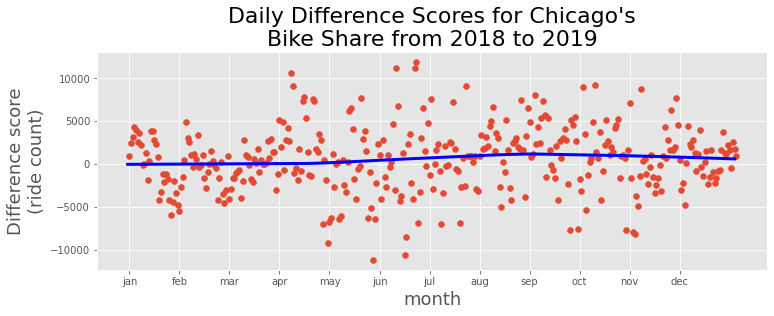

In [75]:
# Chicago '18 to '19 difference scores with lowess trend line

low19 = lowess(ch_1819_diff, x)[:,1]

fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(x, ch_1819_diff)
ax.plot(low19, linewidth=3, color='b')

ax.set_xticks([m for m in range(1,360,30)])
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('Difference score\n(ride count)', fontsize=18)
ax.set_title("Daily Difference Scores for Chicago's\nBike Share from 2018 to 2019", fontsize=22);

In [212]:
ch_1819_Q1 = ch_1819_diff.iloc[0:90]
ch_1819_Q2 = ch_1819_diff.iloc[91:181]
ch_1819_Q3 = ch_1819_diff.iloc[183:274]

In [213]:
# Chicago Q1 vs Q2

stats.ttest_ind(ch_1819_Q1, ch_1819_Q2, equal_var=False)

Ttest_indResult(statistic=-1.2392972506505393, pvalue=0.21745987505029643)

In [214]:
# Chicago Q2 vs Q3

stats.ttest_ind(ch_1819_Q2, ch_1819_Q3, equal_var=False)

Ttest_indResult(statistic=-1.3948197336900579, pvalue=0.16497193570745597)